# AWS-ASDI
EDA on the NOAA Global Historical Climatology Network Daily Dataset. This dataset contains over 200 years worth of climate data, and we will analyze the dataset through the use of data science tools that are scalable (modin and NumS). Because the tools we use are scalable, we are able to run the same code on a laptop and cluster of nodes. Before getting started, make sure you set `num_cpus` in `ray_init()` to the number of physical cores on the CPU running this notebook for optimal performance, otherwise Ray might automatically set it to logical cores that include hyperthreading.

Confirm everything is installed through:
```sh
pip3 install -r requirements
```

When done with the notebook, you can properly shutdown Ray to free all processes and memory using:
```python
ray.shutdown()
```
For convenience, this cell is included at the end of the notebook.

In [1]:
import ray
ray.init(ignore_reinit_error=True, num_cpus=32, _temp_dir="/home/brian/external/aws-asdi/ray_temp"); # Remove or reassign _temp_dir if not enough disk storage on device
import modin.pandas as pd
#import pandas as pd
from nums import numpy as nps
from nums.experimental import nums_modin
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os

2021-07-23 04:28:41,441	INFO services.py:1274 -- View the Ray dashboard at http://127.0.0.1:8265


## Downloading the Data and File Organization
* [Data](https://registry.opendata.aws/noaa-ghcn/)
* [Documentation](https://docs.opendata.aws/noaa-ghcn-pds/readme.html)

We can use AWS CLI to speed things up by downloading it locally. More info about installation is provided [here](https://aws.amazon.com/cli/).

To view files in terminal/command line:
```sh
aws s3 ls s3://noaa-ghcn-pds/ --no-sign-request
```

To download locally (*about 100GB of free data is needed on disk*), we can download directly to our `data/` directory:
```sh
mkdir data
aws s3 cp --recursive s3://noaa-ghcn-pds/csv/ --no-sign-request data
```

If downloading will take too much storage space, we can run this notebook completely off of memory, by setting the `local` tag to `False` under the global variables. Some `.txt` files will be directly loaded from S3, as they are relatively small and are just lookup tables/directories for the `.csv` files.

File directory should look like this:
```
├── data/
├── figures/
├── eda.ipynb
├── README.md
└── requirements.txt
```

Here, we test downloading a `.csv` file directly from the AWS S3 bucket to memory. Ensure this is working before running the next cells.

In [2]:
%%time
climate_2020 = pd.read_csv('s3://noaa-ghcn-pds/csv/2020.csv', header=None)
climate_2020.columns = ["ID", "YEAR/MONTH/DAY", "ELEMENT", "DATA VALUE", "M-FLAG", "Q-FLAG", "S-FLAG", "OBS-TIME"]
climate_2020["YEAR/MONTH/DAY"] = pd.to_datetime(climate_2020["YEAR/MONTH/DAY"], format="%Y%m%d")
del climate_2020 # delete from memory

CPU times: user 7.87 s, sys: 2.4 s, total: 10.3 s
Wall time: 38.3 s


**modin**
```
CPU times: user 11.6 s, sys: 2.99 s, total: 14.6 s
Wall time: 1min 42s
```
**pandas**
```
CPU times: user 25.3 s, sys: 3.68 s, total: 29 s
Wall time: 1min 22s
```

In [3]:
%%time
climate_2020 = pd.read_csv('data/2020.csv', header=None)
climate_2020.columns = ["ID", "YEAR/MONTH/DAY", "ELEMENT", "DATA VALUE", "M-FLAG", "Q-FLAG", "S-FLAG", "OBS-TIME"]
climate_2020["YEAR/MONTH/DAY"] = pd.to_datetime(climate_2020["YEAR/MONTH/DAY"], format="%Y%m%d")
del climate_2020 # delete from memory

CPU times: user 1.56 s, sys: 670 ms, total: 2.23 s
Wall time: 3.41 s


**modin**
```
CPU times: user 1.3 s, sys: 518 ms, total: 1.82 s
Wall time: 2.92 s
```
**pandas**
```
CPU times: user 17 s, sys: 2.16 s, total: 19.2 s
Wall time: 18.7 s
```

## Global Variables and DataFrames
Some variables and DataFrames that will be useful in parsing out data.

For inventory, data is stored like this:

```
Variable	Columns	Type
ID	1-11	CHARACTER
LATITUDE	13-20	REAL
LONGITUDE	22-30	REAL
ELEMENT	32-35	CHARACTER
FIRSTYEAR	37-40	INTEGER
LASTYEAR	42-45	INTEGER
```

Sample query
```
ACW00011604  17.1167  -61.7833 TMAX 1949 1949
```

In [4]:
inventory = pd.read_fwf('s3://noaa-ghcn-pds/ghcnd-inventory.txt', widths=[12, 9, 10, 4, 5, 5], header=None)
inventory.columns = ["ID", "LATITUDE", "LONGITUDE", "ELEMENT", "FIRSTYEAR", "LASTYEAR"]
inventory

,ID,LATITUDE,LONGITUDE,ELEMENT,FIRSTYEAR,LASTYEAR
0,ACW00011604,17.1167,-61.7833,TMAX,1949,1949
1,ACW00011604,17.1167,-61.7833,TMIN,1949,1949
2,ACW00011604,17.1167,-61.7833,PRCP,1949,1949
3,ACW00011604,17.1167,-61.7833,SNOW,1949,1949
4,ACW00011604,17.1167,-61.7833,SNWD,1949,1949
...,...,...,...,...,...,...
704607,ZI000067983,-20.2000,32.6160,PRCP,1951,2020
704608,ZI000067983,-20.2000,32.6160,TAVG,1962,2020
704609,ZI000067991,-22.2170,30.0000,TMAX,1951,1990
704610,ZI000067991,-22.2170,30.0000,TMIN,1951,1990


For stations, the data is formatted like this:
```
Variable	Columns	Type	Example
ID	1-11	Character	EI000003980
LATITUDE	13-20	Real	55.3717
LONGITUDE	22-30	Real	-7.3400
ELEVATION	32-37	Real	21.0
STATE	39-40	Character
NAME	42-71	Character	MALIN HEAD
GSN FLAG	73-75	Character	GSN
HCN/CRN FLAG	77-79	Character
WMO ID	81-85	Character	03980
```

A sample query:
```
AE000041196  25.3330   55.5170   34.0    SHARJAH INTER. AIRP            GSN     41196
```

In [5]:
stations = pd.read_fwf('s3://noaa-ghcn-pds/ghcnd-stations.txt', widths=[12, 9, 10, 7, 3, 31, 4, 4, 6], header=None)
stations.columns = ["ID", "LATITUDE", "LONGITUDE", "ELEVATION", "STATE", "NAME", "GSN FLAG", "HCN/CRN FLAG", "WMO ID"]
stations

,ID,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSN FLAG,HCN/CRN FLAG,WMO ID
0,ACW00011604,17.1167,-61.7833,10.1,NaN,ST JOHNS COOLIDGE FLD,NaN,NaN,NaN
1,ACW00011647,17.1333,-61.7833,19.2,NaN,ST JOHNS,NaN,NaN,NaN
2,AE000041196,25.3330,55.5170,34.0,NaN,SHARJAH INTER. AIRP,GSN,NaN,41196.0
3,AEM00041194,25.2550,55.3640,10.4,NaN,DUBAI INTL,NaN,NaN,41194.0
4,AEM00041217,24.4330,54.6510,26.8,NaN,ABU DHABI INTL,NaN,NaN,41217.0
...,...,...,...,...,...,...,...,...,...
118487,ZI000067969,-21.0500,29.3670,861.0,NaN,WEST NICHOLSON,NaN,NaN,67969.0
118488,ZI000067975,-20.0670,30.8670,1095.0,NaN,MASVINGO,NaN,NaN,67975.0
118489,ZI000067977,-21.0170,31.5830,430.0,NaN,BUFFALO RANGE,NaN,NaN,67977.0
118490,ZI000067983,-20.2000,32.6160,1132.0,NaN,CHIPINGE,GSN,NaN,67983.0


In [6]:
country_codes = pd.read_csv("s3://noaa-ghcn-pds/ghcnd-countries.txt", delimiter="\n", header=None)[0].str.extract('(?P<code>.{2})(?P<country>.{0,})')
country_codes

To request implementation, send an email to feature_requests@modin.org.


,code,country
0,AC,Antigua and Barbuda
1,AE,United Arab Emirates
2,AF,Afghanistan
3,AG,Algeria
4,AJ,Azerbaijan
...,...,...
214,WI,Western Sahara
215,WQ,Wake Island [United States]
216,WZ,Swaziland
217,ZA,Zambia


In [7]:
all_elements = ['ACMC', 'ACMH', 'ACSC', 'ACSH', 'AWDR', 'AWND', 'DAEV', 'DAPR', 'DASF', 'DATN', 'DATX', 'DAWM',
                'DWPR', 'EVAP', 'FMTM', 'FRGB', 'FRGT', 'FRTH', 'GAHT', 'MDEV', 'MDPR', 'MDSF', 'MDTN', 'MDTX', 
                'MDWM', 'MNPN', 'MXPN', 'PGTM', 'PSUN']

"""
frequent elements that have 500 or more data points using
inventory["ELEMENT"].value_counts()
>>>
['PRCP', 'SNOW', 'MDPR', 'SNWD', 'DAPR', 'TMAX', 'TMIN', 'WESD', 'WESF', 'WT01', 'WT03', 
 'TOBS', 'WT05', 'WT04', 'WT11', 'DWPR', 'WT06', 'MDSF', 'TAVG', 'WT14', 'WT08', 'WT16', 
 'WT18', 'DASF', 'WT09', 'WT07', 'WSFG', 'WDFG', 'PGTM', 'WT10', 'AWND', 'WDMV', 'WT02', 
 'EVAP', 'WDF2', 'WSF2', 'WSF5', 'WDF5', 'FMTM', 'TSUN', 'DAEV', 'MDEV', 'MDTN', 'DATN', 
 'MDWM', 'DAWM', 'DATX', 'MDTX', 'MXPN', 'MNPN', 'WT13']
"""
#TODO, add more elements...

# Global variables
elements = ["PRCP", "SNOW", "SNWD", "TMAX", "TMIN"]
years = list(range(1763, 2022))
local = True #Change this flag to False to download data off of s3 storage directly
#TODO, refactor code to be changed by only this variable

## Utility Functions
Some helpful functions in helping with EDA

In [8]:
def df_loader(year, local=False):
    if local:
        df = pd.read_csv('data/' + str(year) + '.csv', header=None)
    else:
        df = pd.read_csv('s3://noaa-ghcn-pds/csv/' + str(year) + '.csv', header=None)
    df.columns = ["ID", "YEAR/MONTH/DAY", "ELEMENT", "DATA VALUE", "M-FLAG", "Q-FLAG", "S-FLAG", "OBS-TIME"]
    df["YEAR/MONTH/DAY"] = pd.to_datetime(df["YEAR/MONTH/DAY"], format="%Y%m%d")
    return df

In [9]:
def df_filter(df, _id, element):
    return df.loc[(df["ID"] == _id) & (df["ELEMENT"] == element)][["YEAR/MONTH/DAY", "DATA VALUE"]].set_index("YEAR/MONTH/DAY").sort_index()

In [10]:
#same as df_filter, but a vector of ALL the data
def df_filter_vector(_id, element, local=False, custom_years=None):
    df_vector = pd.DataFrame(columns=["DATA VALUE"])
    if custom_years:
        years = range(custom_years[0], custom_years[1] + 1)
    for year in tqdm(years):
        if local:
            df = df_filter(dfs[year], _id, element)
        else:
            df = df_filter(df_loader(year), _id, element)
            
        if df_vector.empty:
            df_vector = df
        else:
            df_vector = df_vector.append(df)
    return df_vector

In [11]:
#print statements are replaced with tqdm functions
# MatPlotLib runs on single thread, we can parallelize plotting by using Ray
@ray.remote
def plotter(df, _id, element, save=False, year=None):
    station_name = stations.loc[stations['ID'] == _id]["NAME"].item()
    df = df_filter(df, _id, element)
    
    if df.empty:
        tqdm.write(element + " data on " + str(year) + " for " + station_name + " with id: " + _id + " is empty. Plotting is skipped.")
        return

    plt.figure(figsize=(20, 10))
    plt.plot(df)
    plt.title(element + " Data at " + station_name)
    plt.xlabel("Date")
    plt.ylabel("Value")
    #plt.xlim() #figure out a way to set limit of year
    plt.ylim(-100, 400)
    if save:
        directory = "figures/" + _id + "/" + element
        try:
            # Create target directory
            os.makedirs(directory)
            tqdm.write(f"Directory " + directory + " Created ")
        except FileExistsError:
            tqdm.write(f"Directory " + directory + " already exists. File " + directory + "/" + str(year) + ".png has been saved successfully.")
        
        plt.savefig(directory + "/" + str(year) + ".png")
    plt.clf()

## Loading all the DataFrames to Memory
We can also store all the dataframes into memory, given that there is enough RAM. Dataset is ~100GB, so something more that that should be fine. (Uses 200GB+ of memory on this system)

Skip this cell if running on less RAM.

In [12]:
%%time
dfs = {}
for year in tqdm(years):
    dfs[year] = df_loader(year, local=local) 

  0%|          | 0/259 [00:00<?, ?it/s]

CPU times: user 2min 51s, sys: 54 s, total: 3min 45s
Wall time: 5min 16s


Loading all the dataframes from local storage to memory gives us these times:

**modin**:
```
CPU times: user 2min 48s, sys: 54 s, total: 3min 42s
Wall time: 5min 14s
```

**pandas**
```
CPU times: user 24min 22s, sys: 5min 39s, total: 30min 2s
Wall time: 29min 32s
```

As we can see, modin gives us ~6x speedup, which is impressive considering that ~100GB is being transferred and loaded onto memory.

# EDA
Visualizations and understanding the data

Plot how many data points each country has collected in their weather stations

In [15]:
station_data_freq = pd.DataFrame()
years.reverse() #reverse, so NaNs can be filled in to missing/old data

for year in tqdm(years):
    station_data_freq[year] = dfs[year].groupby(dfs[year]["ID"].str.slice(stop=2))["DATA VALUE"].sum()

years.reverse()
station_data_freq = station_data_freq.fillna(0).T
station_data_freq

  0%|          | 0/259 [00:00<?, ?it/s]

ID,AE,AF,AG,AJ,AL,AM,AO,AQ,AR,AS,...,UZ,VE,VM,VQ,WA,WF,WI,WQ,ZA,ZI
2021,519865.0,67168.0,3365075.0,575644.0,27366.0,528187.0,116387.0,233685.0,5736600.0,65259175.0,...,1665843.0,308660.0,1594501.0,1012654.0,777103.0,288938.0,69554.0,110031.0,1083.0,26033.0
2020,1049427.0,347809.0,6468526.0,1117900.0,149494.0,1063089.0,296152.0,620414.0,10303967.0,121229268.0,...,2944183.0,1060313.0,2830827.0,2002028.0,1310837.0,452695.0,149346.0,95449.0,7404.0,79597.0
2019,965715.0,381186.0,6352635.0,1155516.0,162282.0,1099505.0,264390.0,465857.0,8858792.0,112609962.0,...,3108996.0,540122.0,3350807.0,1938332.0,1793524.0,615150.0,135084.0,189020.0,28963.0,140548.0
2018,888756.0,274279.0,6694154.0,1174363.0,164416.0,1132851.0,208387.0,441797.0,8897612.0,120038907.0,...,2955479.0,1282236.0,2793026.0,1756558.0,1356098.0,476696.0,110540.0,98106.0,15406.0,210488.0
2017,910630.0,209730.0,6374097.0,924363.0,154446.0,998756.0,249585.0,437014.0,9310667.0,124485288.0,...,3090817.0,509367.0,2642634.0,1758009.0,1544604.0,535018.0,72900.0,122131.0,19058.0,387086.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
for index, row in tqdm(country_codes.iterrows()): 
    if row[0] in station_data_freq.T.columns:
        fig = plt.figure(figsize=(10, 10))
        ax = station_data_freq.T[row[0]].plot();
        ax.set_xlabel("Years")
        ax.set_ylabel("Number of Data Points")
        plt.savefig(("figures/datasamples/" + row[1] + ".png").replace(" ", "_"))
        plt.clf()

0it [00:00, ?it/s]

In [17]:
sample_points = []
for year in tqdm(years):
    sample_points.append(len(dfs[year].index))

  0%|          | 0/259 [00:00<?, ?it/s]

Note that there is a dip at the end. That is due to this dataset being collected and updated live. Thus, it includes the year 2021 (the current year making this notebook).

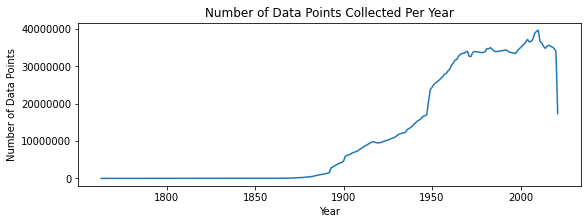

In [18]:
plt.figure(figsize=(9, 3))
plt.plot(years, sample_points);
plt.title("Number of Data Points Collected Per Year")
plt.ticklabel_format(style = 'plain')
plt.xlabel("Year")
plt.ylabel("Number of Data Points");

In [19]:
# Massively plots elements per year for each id
"""
for _id in tqdm(stations["ID"]):
    for element in elements:
        for year in years:
            plotter.remote(dfs[year], _id, element, save=True, year=year)
"""

'\nfor _id in tqdm(stations["ID"]):\n    for element in elements:\n        for year in years:\n            plotter.remote(dfs[year], _id, element, save=True, year=year)\n'

We can also analyze what type of weather data is being collected. Here is a plot of the top 25 weather data being collected ranked by frequency.

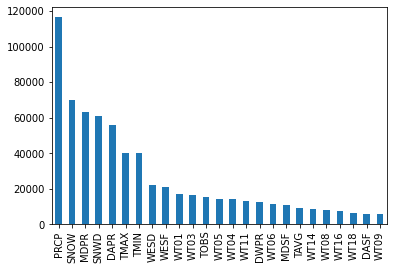

In [20]:
inventory["ELEMENT"].value_counts().head(25).plot(kind="bar");

We can also analyze location of each station by plotting their longitude and latitude to give us a familiar outline:

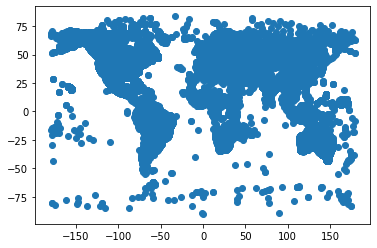

In [122]:
plt.scatter(x=stations['LONGITUDE'], y=stations['LATITUDE']);

In [22]:
dfs[2020][dfs[2020]["ELEMENT"] == "TMIN"]

,ID,YEAR/MONTH/DAY,ELEMENT,DATA VALUE,M-FLAG,Q-FLAG,S-FLAG,OBS-TIME
0,AE000041196,2020-01-01,TMIN,168,NaN,NaN,S,NaN
6,AEM00041218,2020-01-01,TMIN,148,NaN,NaN,S,NaN
12,AFM00040990,2020-01-01,TMIN,45,NaN,NaN,S,NaN
15,AG000060590,2020-01-01,TMIN,-20,NaN,NaN,S,NaN
19,AGE00147708,2020-01-01,TMIN,44,NaN,NaN,S,NaN
...,...,...,...,...,...,...,...,...
33986784,WA007401540,2020-12-31,TMIN,175,NaN,NaN,S,NaN
33986791,WA010517310,2020-12-31,TMIN,194,NaN,NaN,S,NaN
33986795,WAM00068006,2020-12-31,TMIN,224,NaN,NaN,S,NaN
33986803,WFM00091754,2020-12-31,TMIN,260,NaN,NaN,S,NaN


In [60]:
id_location = 

In [63]:
test_df = dfs[1900].merge(id_location, how='inner', on='ID')

In [64]:
test_df

,ID,YEAR/MONTH/DAY,ELEMENT,DATA VALUE,M-FLAG,Q-FLAG,S-FLAG,OBS-TIME,LATITUDE,LONGITUDE,ELEVATION
0,AGE00135039,1900-01-01,TMAX,240,NaN,NaN,E,NaN,35.7297,0.6500,50.0
1,AGE00135039,1900-01-01,TMIN,140,NaN,NaN,E,NaN,35.7297,0.6500,50.0
2,AGE00135039,1900-01-01,PRCP,0,NaN,NaN,E,NaN,35.7297,0.6500,50.0
3,AGE00135039,1900-01-02,TMAX,230,NaN,NaN,E,NaN,35.7297,0.6500,50.0
4,AGE00135039,1900-01-02,TMIN,140,NaN,NaN,E,NaN,35.7297,0.6500,50.0
...,...,...,...,...,...,...,...,...,...,...,...
4600985,USC00047902,1900-12-31,TMIN,33,NaN,NaN,6,NaN,34.4167,-119.6844,4.9
4600986,USC00048839,1900-12-31,TMIN,-44,NaN,NaN,6,NaN,35.0233,-118.7497,434.3
4600987,USC00049367,1900-12-31,TMIN,-56,NaN,NaN,6,NaN,36.3283,-119.2997,92.4
4600988,USC00135131,1900-12-31,SNOW,13,NaN,NaN,0,NaN,42.0772,-90.6647,203.6


In [173]:
test_elements = ['PRCP', 'SNOW', 'MDPR', 'SNWD', 'DAPR', 'TMAX', 'TMIN', 'WESD']

In [179]:
test = transform(dfs[2020], test_elements, dropna=True)

In [180]:
test

,ID,YEAR/MONTH/DAY,DAPR,MDPR,PRCP,SNOW,SNWD,TMAX,TMIN,WESD,LATITUDE,LONGITUDE,ELEVATION
0,AE000041196,2020-01-01,NaN,NaN,0.0,NaN,NaN,NaN,168.0,NaN,25.333,55.517,34.0
1,AE000041196,2020-01-02,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,25.333,55.517,34.0
2,AE000041196,2020-01-03,NaN,NaN,0.0,NaN,NaN,NaN,154.0,NaN,25.333,55.517,34.0
3,AE000041196,2020-01-04,NaN,NaN,0.0,NaN,NaN,NaN,149.0,NaN,25.333,55.517,34.0
4,AE000041196,2020-01-05,NaN,NaN,0.0,NaN,NaN,NaN,165.0,NaN,25.333,55.517,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11757155,ZI000067975,2020-01-16,NaN,NaN,10.0,NaN,NaN,247.0,190.0,NaN,-20.067,30.867,1095.0
11757158,ZI000067975,2020-03-04,NaN,NaN,30.0,NaN,NaN,NaN,155.0,NaN,-20.067,30.867,1095.0
11757162,ZI000067975,2020-06-19,NaN,NaN,20.0,NaN,NaN,NaN,105.0,NaN,-20.067,30.867,1095.0
11757164,ZI000067983,2020-03-07,NaN,NaN,10.0,NaN,NaN,228.0,145.0,NaN,-20.200,32.616,1132.0


In [195]:
data= test

In [196]:
data = data[["PRCP", "TMAX", "TMIN", "LATITUDE", "LONGITUDE", "ELEVATION"]]

In [199]:
data = data.dropna()

In [200]:
data

,PRCP,TMAX,TMIN,LATITUDE,LONGITUDE,ELEVATION
63,0.0,269.0,120.0,25.3330,55.517,34.0
64,0.0,273.0,126.0,25.3330,55.517,34.0
79,0.0,315.0,175.0,25.3330,55.517,34.0
80,0.0,345.0,201.0,25.3330,55.517,34.0
83,0.0,280.0,185.0,25.3330,55.517,34.0
...,...,...,...,...,...,...
11756967,0.0,298.0,239.0,19.2833,166.650,4.3
11757083,0.0,258.0,150.0,-17.9170,31.133,1480.0
11757155,10.0,247.0,190.0,-20.0670,30.867,1095.0
11757164,10.0,228.0,145.0,-20.2000,32.616,1132.0


In [201]:
X = data[["TMAX", "TMIN", "LATITUDE", "LONGITUDE", "ELEVATION"]].to_numpy()

In [202]:
y = data["PRCP"].to_numpy()

In [203]:
y[y > 0] = 1
y

array([0., 0., 0., ..., 1., 1., 1.])

In [204]:
from sklearn.model_selection import train_test_split

In [205]:

from sklearn.linear_model import LinearRegression

model = LinearRegression()

In [206]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [207]:
model.fit(X_train, y_train)

LinearRegression()

In [208]:
model.coef_

array([-3.10240422e-03,  3.17791606e-03,  5.15661217e-04,  2.19204409e-04,
       -1.58585670e-08])

In [209]:
model.score(X_test, y_test)

0.13562953197524052

In [210]:
from sklearn.linear_model import LogisticRegression

In [211]:
model = LogisticRegression(solver="lbfgs")
model.fit(X_train, y_train)

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression()

In [212]:
model.score(X_test, y_test)

0.7107422175223117

In [213]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

In [214]:
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [215]:
model.score(X_train, y_train)

0.9811162674024834

In [216]:
model.score(X_test, y_test)

0.679276172626643

In [217]:
from sklearn.ensemble import RandomForestClassifier
clf =  RandomForestClassifier(n_jobs=32)
clf = clf.fit(X_train, y_train)


In [218]:
clf.score(X_train, y_train)

0.9810879901485696

In [219]:
clf.score(X_test, y_test)

0.7350411046682829

## GeoEDA
https://medium.com/plotly/how-to-create-2d-and-3d-interactive-weather-maps-in-python-and-r-77ddd53cca8
conda install basemap

Next, let's analyze and plot data from a weather station. We will analyze the station USC00040693 in Berkeley, CA [(Google Maps)](https://www.google.com/maps/place/37°52'27.8%22N+122°15'38.2%22W/@37.8744024,-122.2618614,17z/data=!3m1!4b1!4m5!3m4!1s0x0:0x0!8m2!3d37.8744!4d-122.2606). Through Pandas/modin, we can figure out which elements of weather data this station records:

In [21]:
inventory[inventory["ID"] == 'USC00040693']

,ID,LATITUDE,LONGITUDE,ELEMENT,FIRSTYEAR,LASTYEAR
388869,USC00040693,37.8744,-122.2606,TMAX,1893,2021
388870,USC00040693,37.8744,-122.2606,TMIN,1893,2021
388871,USC00040693,37.8744,-122.2606,TOBS,1901,2020
388872,USC00040693,37.8744,-122.2606,PRCP,1893,2021
388873,USC00040693,37.8744,-122.2606,SNOW,1899,2010
388874,USC00040693,37.8744,-122.2606,SNWD,1913,2010
388875,USC00040693,37.8744,-122.2606,DAPR,1953,2012
388876,USC00040693,37.8744,-122.2606,MDPR,1953,2012
388877,USC00040693,37.8744,-122.2606,WT01,1893,1997
388878,USC00040693,37.8744,-122.2606,WT03,1915,1988


Data will vary a lot between stations, some stations may record as little as just precipitation. Coincidentally, this weather station is located on UC Berkeley campus and has been recording data of various elements for quite a while. The more interesting data values recorded in this station other than temperature and precipitation are the WT** data types. According to the [documentation](https://docs.opendata.aws/noaa-ghcn-pds/readme.html) they are mapped to:

* **01 = Fog, ice fog, or freezing fog (may include heavy fog)**
* 02 = Heavy fog or heaving freezing fog (not always distinguished from fog)
* **03 = Thunder**
* **04 = Ice pellets, sleet, snow pellets, or small hail**
* **05 = Hail (may include small hail)**
* 06 = Glaze or rime
* 07 = Dust, volcanic ash, blowing dust, blowing sand, or blowing obstruction
* **08 = Smoke or haze**
* 09 = Blowing or drifting snow
* 10 = Tornado, waterspout, or funnel cloud
* **11 = High or damaging winds**
* 12 = Blowing spray
* 13 = Mist
* **14 = Drizzle**
* 15 = Freezing drizzl
* 16 = **Rain (may include freezing rain, drizzle, and freezing drizzle)**
* 17 = Freezing rain
* 18 = Snow, snow pellets, snow grains, or ice crystals
* 19 = Unknown source of precipitation
* 21 = Ground fog
* 22 = Ice fog or freezing fog

Unfortunately, plotting these special elements out shows us there is nothing interesting going.

In [383]:
#TODO: Make dataloading faster by batching operations into a design matrix with features, if possible. 
#Currently 7-8s per iteration, at most 12 min per vector
berkeley_weather_elements = inventory[inventory["ID"] == 'USC00040693'][["ELEMENT", "FIRSTYEAR", "LASTYEAR"]]
berkeley_weather_elements = berkeley_weather_elements[berkeley_weather_elements["ELEMENT"].isin(["TMAX", "TMIN", "PRCP"])] #override to save time
berkeley_time_series = {}

for _, rows in berkeley_weather_elements.iterrows():
    element, firstyear, lastyear = rows
    berkeley_time_series[element] = df_filter_vector('USC00040693', element, local=True, custom_years=(lastyear-20, lastyear - 1)) #only grabbing the last 20 years for effiency

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

We can plot data in the last 3 years, (plotting all of the data will take a long time due to the bottleneck of matplotlib).

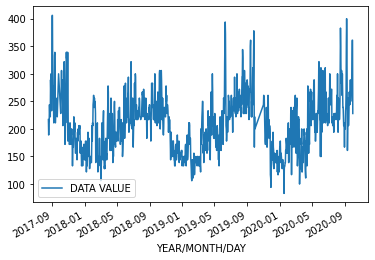

In [384]:
berkeley_time_series["TMAX"].tail(365 * 3).plot();

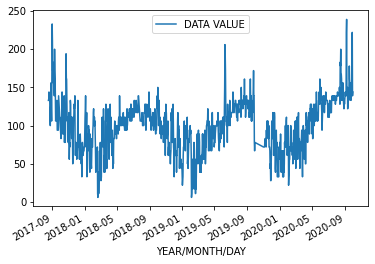

In [385]:
berkeley_time_series["TMIN"].tail(365 * 3).plot();

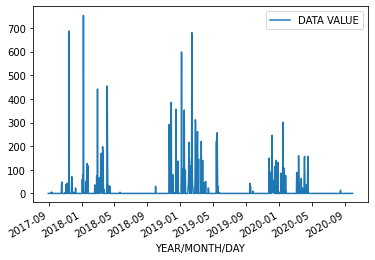

In [386]:
berkeley_time_series["PRCP"].tail(365 * 3).plot();

# Modeling
#TODO: Refactor modeling portion to a separate notebook after done experimenting

##### Helper Functions
Some functions to aid in modeling with NumS and Modin.

In [47]:
def train_test_split(X, y, validation_size, seed=None):
    """
    Same thing as sklearn_train_test_split, but with NumS arrays.
    This will be useful for time dependent models
    """
    training = X
    labels = y
    validation_size = int(validation_size * training.shape[0])

    shuffler = nps.random.RandomState(seed=seed).permutation(training.shape[0])
    training_shuffled = training[shuffler]
    labels_shuffled = labels[shuffler]
    
    X_train = training_shuffled[validation_size:]
    Y_train = labels_shuffled[validation_size:]
    
    X_validation = training_shuffled[:validation_size]
    Y_validation = labels_shuffled[:validation_size]
    
    return X_train, Y_train, X_validation, Y_validation


def rmse(actual, expected):
    """
    Computes the root mean squared error to evaluate models/predictions. It can accept all the datatypes used
    in this notebook
    """
    if type(actual) != type(expected):
        raise TypeError("actual and expected must be the same types")
    if type(actual) == np.ndarray:
        return np.sqrt(np.mean((expected - actual) ** 2))
    elif type(actual) == nums.core.array.blockarray.BlockArray:
        return nps.sqrt(nps.mean((expected - actual) ** 2))
    elif type(actual) == modin.pandas.dataframe.DataFrame or type(actual) == pandas.core.frame.DataFrame:
        #TODO
        raise NotImplementedError
    else:
        raise TypeError

In [14]:
def design_matrix(df, elements, dropna=False, target=None):
    df = df[df['ELEMENT'].isin(elements)]
    df = pd.pivot_table(df, index=["ID", "YEAR/MONTH/DAY"], columns="ELEMENT", values="DATA VALUE").reset_index(level=[0,1])
    df = df.merge(stations[["ID", "LATITUDE", "LONGITUDE", "ELEVATION"]], how='inner', on='ID')
    if dropna and target:
        df = df.dropna(subset=target)
    return df

In [15]:
def design_matrix_time_series_stack(_id, element, years, convert_nps=True, local=False):
    """
    Inputs are station ID and element
    Output is a design matrix of time series per year stacked on top of each other.
    rows are year of data collected, 
    cols are day of the year
    
    returns NumS array or Pandas DataFrame
    """
    df_design = pd.DataFrame(columns=pd.date_range(start="2020-01-01", end="2020-12-31").strftime('%m-%d'))
    station_name = stations.loc[stations['ID'] == _id]["NAME"].item()
    
    for year in tqdm(years):
        if local:
            df = dfs[year]
        else:
            try:
                df = df_loader(year)
            except ClientError:
                tqdm.write(str(year) + ".csv doesn't exist on remote, addition to design matrix is skipped.")
                continue
            
        df = df_filter(df, _id, element)
        if df.empty:
            tqdm.write(element + " data on " + str(year) + " for " + station_name + " with id: " + _id + " is empty. Addition to design matrix is skipped.")
            continue
        df.index = df.index.strftime('%m-%d')
        df.columns = [year]
        df = df.T
        df_design = df_design.append(df)


    df_design.index.name = None
    if convert_nps:
        #return nums_modin.from_modin(df_design) #uncomment this once bug gets fixed. 
        return nps.array(df_design.to_numpy().astype(np.double))
    return df_design

## Simple Modeling with FFT
Using NumPy's FFT module to forecast seasonal weather patterns by extrapolation. A function will be extrapolated with FFT on the training dataset and then we can evaluate how well we extrapolated using root mean squared error. We can also tune the variables such as `ratio`, `predict`, and `n_harm` which represents ratio between training and test set, number of days to predict in test set, and frequency of FFT respectively. Tuning these will help avoiding overfitting.

* Source: https://gist.github.com/tartakynov/83f3cd8f44208a1856ce
* StackOverflow Post: https://stackoverflow.com/questions/4479463/using-fourier-analysis-for-time-series-prediction

In [390]:
def fourier_extrapolation(X, n_predict, n_harm=100):
    n = X.size
    t = np.arange(0, n)
    p = np.polyfit(t, X, 1)            # find linear trend in x
    X_notrend = X - p[0] * t           # detrended x
    X_freqdom = np.fft.fft(X_notrend)  # detrended x in frequency domain
    f = np.fft.fftfreq(n)              # frequencies
    indexes = list(range(n))
    indexes.sort(key = lambda i: np.absolute(f[i]))
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(X_freqdom[i]) / n   # amplitude
        phase = np.angle(X_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t

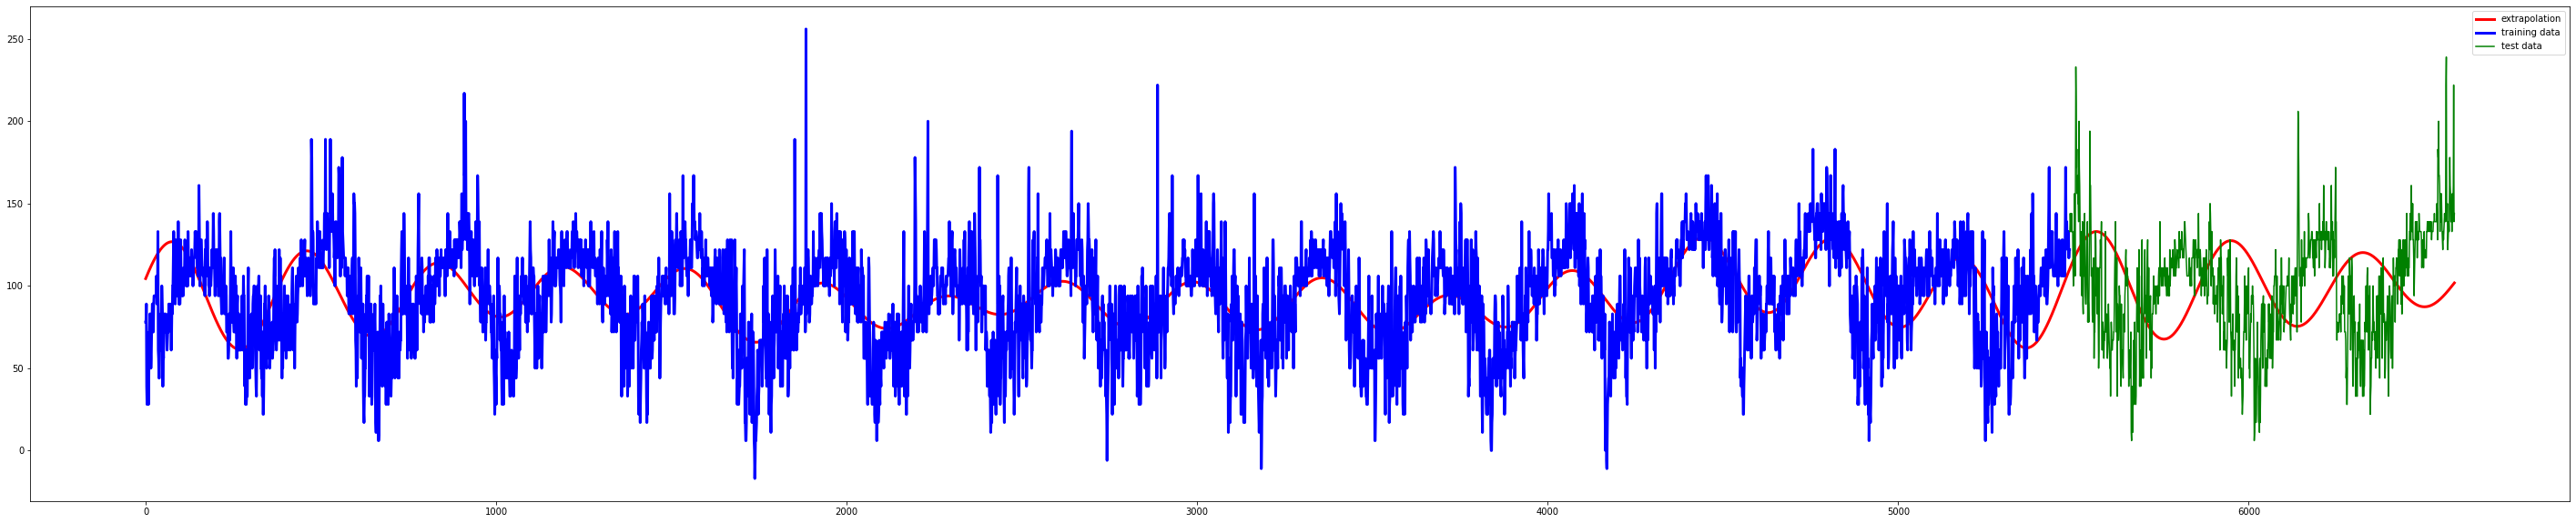

In [519]:
ratio = 6      # Ratio will be train:test = ratio:1
predict = 366 * 3 # Number of future days to predict
n_harm = 15

X_train = berkeley_time_series["TMIN"].sort_index().iloc[-ratio * predict:-predict].to_numpy().reshape(-1) 
X_test = berkeley_time_series["TMIN"].sort_index().iloc[-predict:].to_numpy().reshape(-1) 

extrapolation = fourier_extrapolation(X_train, predict, n_harm=n_harm)
plt.figure(figsize=(50, 10))
plt.plot(np.arange(0, extrapolation.size), extrapolation, 'r', label = 'extrapolation', linewidth=3)
plt.plot(np.arange(0, X_train.size), X_train, 'b', label = r'training data', linewidth = 3)
plt.plot(np.arange(X_train.size, extrapolation.size), X_test, 'g', label = r'test data')
plt.legend()
plt.savefig("fft_berkeley_tmin.png")

In [520]:
rmse(extrapolation[-X_test.size:], X_test)

42.69312862202003

For more sporadic data like precipitation, it's much more harder to predict and identify trends with FFT, thus giving a large RMSE value compared to temperature.

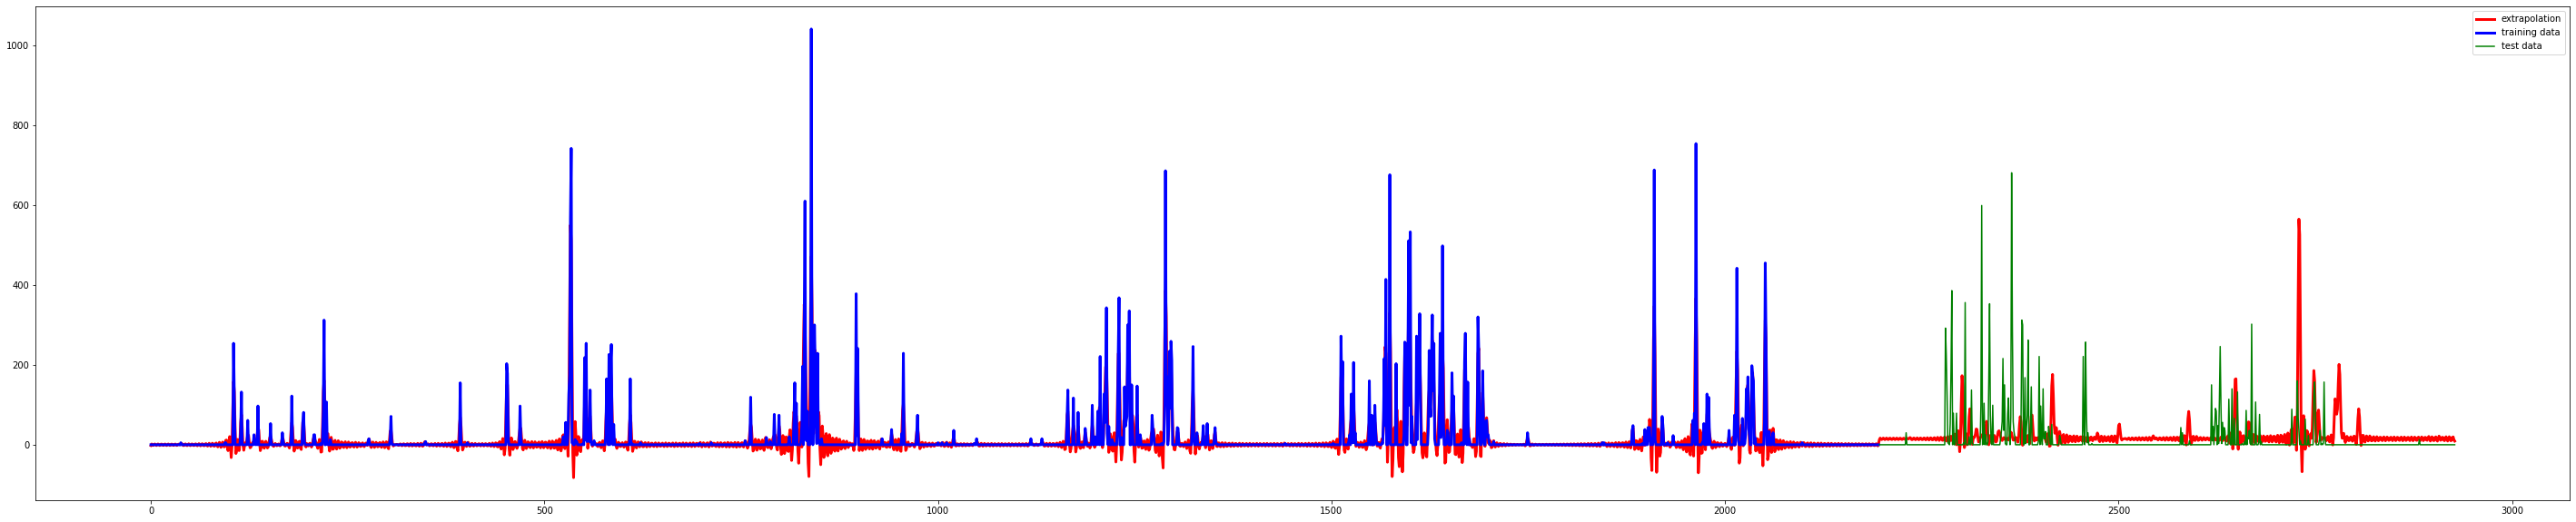

In [521]:
ratio = 4
predict = 366 * 2 # Number of future days to predict
n_harm = 500

X_train = berkeley_time_series["PRCP"].sort_index().iloc[-ratio * predict:-predict].to_numpy().reshape(-1) 
X_test = berkeley_time_series["PRCP"].sort_index().iloc[-predict:].to_numpy().reshape(-1) 

extrapolation = fourier_extrapolation(X_train, predict, n_harm=n_harm)
plt.figure(figsize=(50, 10))
plt.plot(np.arange(0, extrapolation.size), extrapolation, 'r', label = 'extrapolation', linewidth=3)
plt.plot(np.arange(0, X_train.size), X_train, 'b', label = r'training data', linewidth = 3)
plt.plot(np.arange(X_train.size, extrapolation.size), X_test, 'g', label = r'test data')
plt.legend()
plt.savefig("fft_berkeley_prcp.png")

In [522]:
rmse(extrapolation[-X_test.size:], X_test)

69.87441163404335

## Linear Regression with NumS and Time Series Data

In [523]:
from nums.models.glms import LinearRegression

In [592]:
y_train = berkeley_time_series["TMIN"].to_numpy().reshape(-1) 
y_test = berkeley_time_series["TMIN"].to_numpy().reshape(-1) 

#convert to NumS arrays, assigning to y since we want X to be time, y to be TMIN (data value)
y_train = nps.array(y_train)
y_test = nps.array(y_test)

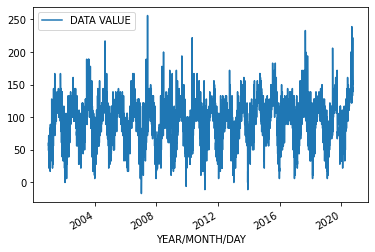

In [596]:
berkeley_time_series["TMIN"].plot()

In [602]:
X_train = nps.arange(0, y_train.shape[0], 1).reshape(-1, 1).astype(np.double)
X_test = nps.arange(y_train.shape[0], y_train.shape[0] + y_test.shape[0], 1).reshape(-1, 1).astype(np.double)

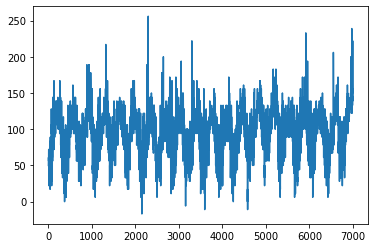

In [603]:
plt.plot(X_train.get(), y_train.get())

We can attempt to fit the time series vector of temperature with NumS linear regression. Nothing interesting should be happening, but shows us how NumS can solve linear regression in a simple case.

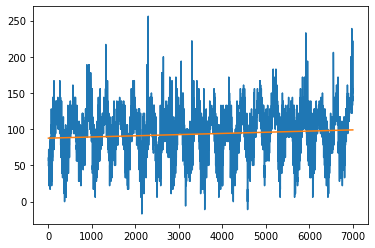

In [606]:
model = LinearRegression()
model.fit(X_train, y_train)

m = model._beta.get()
b = model._beta0.get()

plt.plot(X_train.get(), y_train.get())
plt.plot(X_train.get(), m * X_train.get() + b)

Model also reveals to use that there is only a slight positive trend in data with the slope obtained from:

In [608]:
model._beta.get()

array([0.00163069])

## Linear Regression with NumS and Multiple Features
Next, we can create a design matrix with multiple features as elements and perform Linear Regression. In the next few cells, we will try to perform regression from data over all of world! Let's try to perform regression on snow data. Note that what we are doing is *time-independent* opposed to the previous example with time series.

In [16]:
%%time
test_elements = ["PRCP", "SNOW", "TMAX", "TMIN"]
data = design_matrix(dfs[2020], test_elements, dropna=True, target=["SNOW"])
data

Order of columns could be different from pandas.


CPU times: user 16.4 s, sys: 3.25 s, total: 19.7 s
Wall time: 52.4 s


,ID,YEAR/MONTH/DAY,PRCP,SNOW,TMAX,TMIN,LATITUDE,LONGITUDE,ELEVATION
1591161,BF1BI000001,2020-07-16,0.0,0.0,NaN,NaN,25.7371,-79.2908,7.6
1591172,BF1EX000001,2020-01-07,0.0,0.0,NaN,NaN,23.5069,-75.7694,3.0
1591173,BF1EX000001,2020-01-08,0.0,0.0,NaN,NaN,23.5069,-75.7694,3.0
1591175,BF1EX000001,2020-01-14,0.0,0.0,NaN,NaN,23.5069,-75.7694,3.0
1591176,BF1EX000001,2020-01-15,0.0,0.0,NaN,NaN,23.5069,-75.7694,3.0
...,...,...,...,...,...,...,...,...,...
11666126,VQ1VIST0004,2020-12-19,0.0,0.0,NaN,NaN,18.3380,-64.8560,9.1
11666128,VQ1VIST0004,2020-12-21,0.0,0.0,NaN,NaN,18.3380,-64.8560,9.1
11666133,VQ1VIST0004,2020-12-26,0.0,0.0,NaN,NaN,18.3380,-64.8560,9.1
11666136,VQ1VIST0004,2020-12-29,0.0,0.0,NaN,NaN,18.3380,-64.8560,9.1


In [17]:
data = data.dropna()

In [18]:
data["YEAR/MONTH/DAY"] = data["YEAR/MONTH/DAY"].apply(lambda x: pd.Period(x, freq='D').day_of_year)

In [28]:
data = data.drop(["ID"], axis=1).astype(float)

In [29]:
data

,YEAR/MONTH/DAY,PRCP,SNOW,TMAX,TMIN,LATITUDE,LONGITUDE,ELEVATION
1625893,169.0,0.0,0.0,220.0,110.0,48.9333,-123.7500,75.0
1625894,170.0,0.0,0.0,240.0,120.0,48.9333,-123.7500,75.0
1625895,171.0,64.0,0.0,225.0,140.0,48.9333,-123.7500,75.0
1625896,172.0,18.0,0.0,235.0,155.0,48.9333,-123.7500,75.0
1625897,173.0,0.0,0.0,225.0,140.0,48.9333,-123.7500,75.0
...,...,...,...,...,...,...,...,...
11642434,359.0,0.0,0.0,-77.0,-149.0,43.1561,-90.6775,204.8
11642435,360.0,0.0,0.0,-49.0,-171.0,43.1561,-90.6775,204.8
11642436,361.0,0.0,0.0,-5.0,-132.0,43.1561,-90.6775,204.8
11642438,363.0,0.0,0.0,-21.0,-155.0,43.1561,-90.6775,204.8


In [56]:
X = data[['YEAR/MONTH/DAY', 'PRCP', 'TMAX', 'TMIN', 'LATITUDE', 'LONGITUDE', 'ELEVATION']].to_numpy()
y = data[['SNOW']].to_numpy()

We can set y to be a binary variable. 

In [57]:
y[y > 0] = 1

In [58]:
X = nps.array(X)
y = nps.array(y)

Let's split the data into a training and testing set

In [59]:
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.2, seed=42)

In [69]:
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

In [70]:
from nums.models.glms import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

In [83]:
results = model.predict(X_test).get()
results[results >= 0.5] = 1
results[results < 0.5] = 0
rmse(results, y_test.get())

0.22321983930678801

In [84]:
np.sum(results == y_test.get()) / y_test.shape[0]

0.9501729033398517

In [86]:
results = model.predict(X_train).get()
results[results >= 0.5] = 1
results[results < 0.5] = 0
rmse(results, y_train.get())

0.22213233571739086

In [87]:
np.sum(results == y_train.get()) / y_train.shape[0]

0.9506572254287363

## Logistic Regression with NumS and Multiple Features
A continutation from the previous module, we can also use NumS logistic regression to classify if it will snow or not.

In [90]:
from nums.models.glms import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

In [91]:
results = model.predict(X_test).get()
results[results >= 0.5] = 1
results[results < 0.5] = 0
rmse(results, y_test.get())

0.22898571337277562

In [92]:
np.sum(results == y_test.get()) / y_test.shape[0]

0.947565543071161

In [93]:
results = model.predict(X_train).get()
results[results >= 0.5] = 1
results[results < 0.5] = 0
rmse(results, y_train.get())

0.22762053989085465

In [94]:
np.sum(results == y_train.get()) / y_train.shape[0]

0.9481888898197959

#### Sanity Check, delete later?

In [96]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train.get(), y_train.get())

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression()

In [98]:
model.score(X_test.get(), y_test.get())

0.9475765912078928

## Decision Trees/Random Forest with Intel(R) Extension for Scikit-learn

In [128]:
!pip3 install scikit-learn-intelex

     |████████████████████████████████| 68 kB 2.7 MB/s eta 0:00:011
     |████████████████████████████████| 15.9 MB 11.0 MB/s eta 0:00:01
  Using cached daal-2021.3.0-py2.py3-none-manylinux1_x86_64.whl (292.9 MB)
  Using cached tbb-2021.3.0-py2.py3-none-manylinux1_x86_64.whl (4.1 MB)


In [129]:
from sklearnex import patch_sklearn #using version of sklearn optimized for intel
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [131]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(X_train.get(), y_train.get())

DecisionTreeClassifier()

In [132]:
model.score(X_train.get(), y_train.get())

1.0

In [133]:
model.score(X_test.get(), y_test.get())

0.9761139283859777

In [134]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_jobs=32)
model.fit(X_train.get(), y_train.get())

sklearn.ensemble.RandomForestClassifier.fit: running accelerated version on CPU


RandomForestClassifier(n_jobs=32)

In [135]:
model.score(X_train.get(), y_train.get())

sklearn.ensemble.RandomForestClassifier.predict: running accelerated version on CPU


0.9985131063004704

In [136]:
model.score(X_test.get(), y_test.get())

sklearn.ensemble.RandomForestClassifier.predict: running accelerated version on CPU


0.9844073963592707

## PCA with NumS
We can stack years of data on top of each other to give a design matrix of years as cols/features, and day of the year as rows/data point. Running PCA can tell us if there is any abnormality weather between the years. Continuing with the data from Berkeley, this is what the data shows:

Source/inspriation: https://towardsdatascience.com/the-pca-trick-with-time-series-d40d48c69d28

In [99]:
berkeley_tmax_design_matrix = design_matrix_time_series_stack('USC00040693', 'TMAX', years, local=local)

  0%|          | 0/259 [00:00<?, ?it/s]

TMAX data on 1763 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
TMAX data on 1764 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
TMAX data on 1765 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
TMAX data on 1766 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
TMAX data on 1767 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
TMAX data on 1768 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
TMAX data on 1769 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
TMAX data on 1770 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
TMAX data on 1771 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
TMAX data on 1772 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.


2021-07-23 05:06:47,303	ERROR worker.py:79 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::deploy_ray_func() (pid=7014, ip=10.0.0.4)
  File "/home/brian/external/anaconda3/envs/nums/lib/python3.7/site-packages/modin/engines/base/frame/data.py", line 824, in astype_builder
    return df.astype({k: v for k, v in col_dtypes.items() if k in df})
  File "/home/brian/external/anaconda3/envs/nums/lib/python3.7/site-packages/pandas/core/generic.py", line 5862, in astype
    col.astype(dtype=dtype[col_name], copy=copy, errors=errors)
  File "/home/brian/external/anaconda3/envs/nums/lib/python3.7/site-packages/pandas/core/generic.py", line 5877, in astype
    new_data = self._mgr.astype(dtype=dtype, copy=copy, errors=errors)
  File "/home/brian/external/anaconda3/envs/nums/lib/python3.7/site-packages/pandas/core/internals/managers.py", line 631, in astype
    return self.apply("astype", dtype=dtype, copy=copy, errors=errors)
  File "/home/brian/external/anaconda3/envs/nums

TMAX data on 1798 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
TMAX data on 1799 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
TMAX data on 1800 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
TMAX data on 1801 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
TMAX data on 1802 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
TMAX data on 1803 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
TMAX data on 1804 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
TMAX data on 1805 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
TMAX data on 1806 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
TMAX data on 1807 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.


TMAX data on 1903 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
TMAX data on 1904 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
TMAX data on 1991 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
TMAX data on 1992 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.


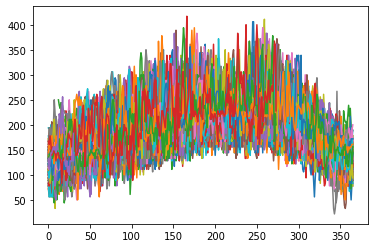

In [111]:
for i in range(berkeley_tmax_design_matrix.shape[0]):
    plt.plot(berkeley_tmax_design_matrix[i].get());

Seems like the data has one significant feature, which should be expected. Also notice a jump near day 50, indicating that this is around February, when leap days occur, causing inconsistencies in data. There are also some abnormalities in the other dimensions, potentially indicating shifts/differences in climate change.

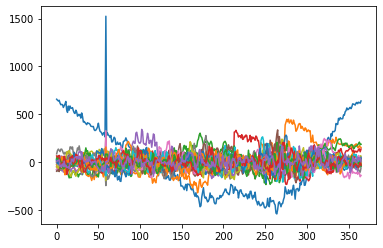

In [112]:
#Using sklearn as sanity check
from sklearn.decomposition import PCA

X = np.nan_to_num(berkeley_tmax_design_matrix.T.get())
pca = PCA(n_components=25)
plt.plot(pca.fit_transform(X));

In [113]:
%%time
U, S, V = np.linalg.svd(np.nan_to_num(berkeley_tmax_design_matrix.T.get()), full_matrices=False)

CPU times: user 10.3 ms, sys: 223 µs, total: 10.5 ms
Wall time: 9.57 ms


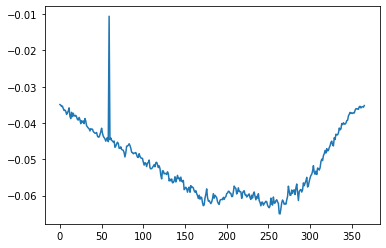

In [114]:
plt.plot(U.T[0, :])

In [115]:
from nums.core import linalg
from nums.core import application_manager
nps_app_inst = application_manager.instance()

In [116]:
%%time
U, S, V = linalg.svd(nps_app_inst, nps.nan_to_num(berkeley_tmax_design_matrix.T))
U.touch() #for timing purposes
S.touch()
V.touch()

CPU times: user 10.2 ms, sys: 23.6 ms, total: 33.8 ms
Wall time: 29.2 ms


BlockArray([[Block(ObjectRef(356c43c682015f09ffffffffffffffffffffffff0100000003000000))]])

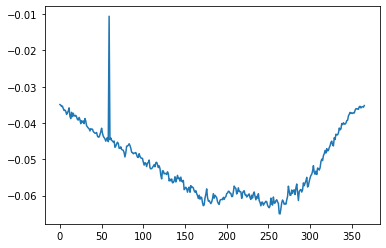

In [117]:
plt.plot(U.T[0, :].get())

Scree Plot of the first 10 singular values

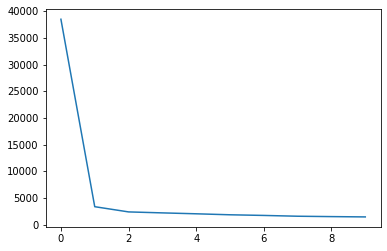

In [118]:
plt.plot(S[:10].get())

Let's repeat the same with precipication data:

In [119]:
berkeley_prcp_design_matrix = design_matrix_time_series_stack('USC00040693', 'PRCP', years, local=local)

  0%|          | 0/259 [00:00<?, ?it/s]

PRCP data on 1763 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
PRCP data on 1764 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
PRCP data on 1765 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
PRCP data on 1766 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
PRCP data on 1767 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
PRCP data on 1768 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
PRCP data on 1769 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
PRCP data on 1770 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
PRCP data on 1771 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
PRCP data on 1772 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.


PRCP data on 1903 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
PRCP data on 1904 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
PRCP data on 1991 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
PRCP data on 1992 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.


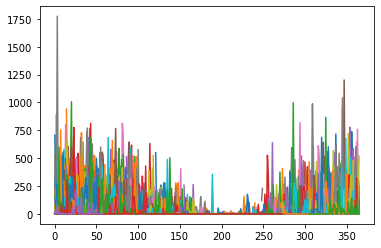

In [122]:
for i in range(berkeley_prcp_design_matrix.shape[0]):
    plt.plot(berkeley_prcp_design_matrix[i].get());

In [123]:
U, S, V = linalg.svd(nps_app_inst, nps.nan_to_num(berkeley_prcp_design_matrix.T))

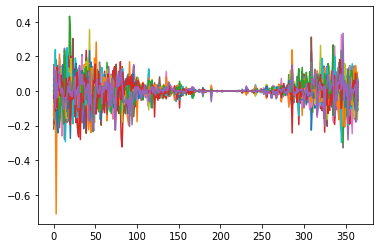

In [125]:
for i in range(25):
    plt.plot(U.T[i, :].get());

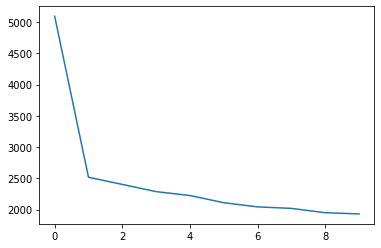

In [127]:
#scree plot
plt.plot(S[:10].get());

## Modeling using GreyKite

In [36]:
import greykite

In [316]:
from nums.experimental import nums_modin

In [332]:
nums_modin.from_modin

<function nums.experimental.nums_modin.from_modin(df)>

In [270]:
np.save("test.npy", berkeley_tmax_design_matrix.get())

In [53]:
design_matrix = nps.array(np.load("test.npy"))

In [201]:
design_matrix.shape

In [ ]:
nums_modin.from_modin(a[["DATA VALUE"]].astype(np.int))

In [202]:
A = nps.nan_to_num(design_matrix)
y = nps.arange(1775, design_matrix.shape[0] + 1775, 1)
#y = nps.arange(1, 367, 1)
y.shape

(230,)

test modeling with sklearn

In [203]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=False)
model.fit(A.get(), y.get())
sklearn_coef = model.coef_

In [70]:
model.predict(A.T.get())

array([ 11.22544643, -11.39701756,  27.85382419, -20.80285796,
        23.94157638,  11.40298083,  12.09276171,  24.24316084,
        22.66869712, -20.24946541,   7.818794  ,  25.50337546,
         8.65191324,   3.1242617 ,  42.13707677,  18.56022956,
        15.10400813, -19.05559764,  34.70490197,  22.98622813,
        29.61296812,  30.32066065,  28.91341826,  -7.57697434,
        19.22860071,  29.73779187,  20.11514675,  44.99971802,
        29.22262733,   3.0114597 ,  13.62014022,  43.49648153,
        31.40635413,  16.40835786,  58.51504472,  28.9413034 ,
        53.42651624,  52.48566979,   6.1861793 ,  52.17528266,
        70.66437875,  37.31046956,  25.24377327,  73.11381063,
        44.77725763,  22.67077448,  58.22805161,  54.37781247,
        55.36788513,  64.42747089,  42.47747741,  56.50161302,
        26.51044255,  35.16485747,  75.15855502,  88.68624745,
        56.09914193,  51.01559368,  45.71636336,  44.41218873,
        53.11226924,  84.93277644,  90.67358738,  37.70

In [152]:
result1, result2, result3, result4 = np.linalg.lstsq(A.get(), y.get(), rcond=None)
result1.shape

(366,)

In [153]:
from nums.models.glms import LinearRegression

In [154]:
LinearRegression

nums.models.glms.LinearRegression

In [155]:
model = LinearRegression()
model.fit(A, y)

In [158]:
model._beta.get();

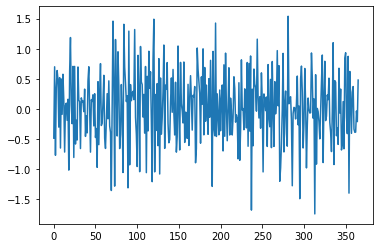

In [157]:
plt.plot(sklearn_coef)

In [ ]:
model.predict(design_matrix[0]).get()

In [ ]:
block_shape = design_matrix.T.block_shape
shape = design_matrix.T.shape
R_shape = (shape[1], shape[1])
R_block_shape = (block_shape[1], block_shape[1])

In [346]:
a = berkeley_time_series["TMAX"].tail(365 * 6)
a

,DATA VALUE
YEAR/MONTH/DAY,
2014-08-25,233
2014-08-26,228
2014-08-27,239
2014-08-28,256
2014-08-29,256
...,...
2021-01-27,128
2021-01-28,128
2021-01-29,128


In [354]:
a[["DATA VALUE"]].astype(np.int)

Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


,DATA VALUE
YEAR/MONTH/DAY,
2014-08-25,233
2014-08-26,228
2014-08-27,239
2014-08-28,256
2014-08-29,256
...,...
2021-01-27,128
2021-01-28,128
2021-01-29,128


In [378]:
frame = a[["DATA VALUE"]].astype(np.int)
frame

Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


,DATA VALUE
YEAR/MONTH/DAY,
2014-08-25,233
2014-08-26,228
2014-08-27,239
2014-08-28,256
2014-08-29,256
...,...
2021-01-27,128
2021-01-28,128
2021-01-29,128


In [176]:
elements

['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN']

In [183]:
df_filter(dfs[2000], "CA006158350", "PRCP")

,DATA VALUE
YEAR/MONTH/DAY,
2000-01-01,0
2000-01-02,18
2000-01-03,46
2000-01-04,0
2000-01-05,0
...,...
2000-12-27,0
2000-12-28,0
2000-12-29,38


In [190]:
elements

['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN']

In [ ]:
def create_time_series_design_matrix(_id, element, features):
    df = pd.DataFrame(columns=features)
    for year in tqdm(years):
        

In [196]:
df = pd.DataFrame(columns=elements)
#for year in tqdm(years):
year = 2000
for feature in ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN']:
    df[feature] = df_filter(dfs[year], "CA006158350", feature)

In [203]:
A = nps.array(df[['PRCP', 'TMAX', 'TMIN']].to_numpy())

In [204]:
y = nps.array(df['SNOW'].to_numpy())

In [205]:
from nums.models.glms import LogisticRegression

In [206]:
model = model.fit(A, y)

AttributeError: 'NoneType' object has no attribute 'fit'

In [ ]:
%%time
tmin = climate_2020[climate_2020["ELEMENT"] == "TMIN"]
tmax = climate_2020[climate_2020["ELEMENT"] == "TMAX"]

In [ ]:
precipication["DATA VALUE"].plot()

In [ ]:
snow = climate_2020[climate_2020["ELEMENT"] == "SNOW"]
snow_depth = climate_2020[climate_2020["ELEMENT"] == "SNWD"]

In [ ]:
snow["DATA VALUE"].plot()

In [ ]:
snow = climate_2020[climate_2020["ELEMENT"] == "SNOW"]

In [ ]:
climate_2020["country_code"] = climate_2020["ID"].str.slice(stop=2)

In [ ]:
climate_2020

In [ ]:
climate_2020[climate_2020["country_code"] == "US"]

In [ ]:
climate_2020[climate_2020["ID"] == "US10adam002"]

In [ ]:
climate_2020[climate_2020["ID"] == "US10adam002"].plot(x = "YEAR/MONTH/DAY", y="DATA VALUE")
climate_2020[climate_2020["ID"] == "USW00096408"].plot(x = "YEAR/MONTH/DAY", y="DATA VALUE")
climate_2020[climate_2020["ID"] == "US10adam002"].plot(x = "YEAR/MONTH/DAY", y="DATA VALUE")

When done, run this so you can properly shutdown Ray

In [138]:
del dfs

In [139]:
ray.shutdown()